In [1]:
#  Author: 2021. Jingyan Li
#  Track speed/volume changes for validation days

import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib.patches as patches
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
from utils import dataload_utils


In [2]:
DATA_DIR = r"C:\Users\jingyli\OwnDrive\IPA\data\2021_IPA\ori\Berlin\validation"
FIG_DIR = r"C:\Users\jingyli\OwnDrive\IPA\result\raw_data_stats"

file_paths = glob.glob(os.path.join(DATA_DIR,'*.h5'))
file_names = [f.split("\\")[-1].split("_")[0] for f in file_paths]

# Load Data

In [3]:
# Road Mask
MASK_PATH = r"C:\Users\jingyli\OwnDrive\IPA\python-eda-code\utils\Berlin.mask"

road = pickle.load(open(MASK_PATH, "rb"))

In [4]:
# Speed/Volume/incident
volume_arr = np.zeros((18, 288, 495, 436))
speed_arr = np.zeros((18, 288, 495, 436))
incident_arr = np.zeros((18, 288, 495, 436))

volume_idx = np.arange(0,8,2)
speed_idx = np.arange(1,8,2)
# Iterate through all days and get the speed/volume per pixel
for i, file in enumerate(glob.glob(os.path.join(DATA_DIR,"*.h5"))):
    d = dataload_utils.load_h5_file(file)
    v = np.mean(d[:, :, :, volume_idx], axis=-1)
    s = np.mean(d[:, :, :, speed_idx], axis=-1)
    ic = d[:, :, :, -1]
    volume_arr[i] = v
    speed_arr[i] = s
    incident_arr[i] = ic
    del d,v,s,ic
    print(file.split("\\")[-1])
#     if i==0:
#         break

2019-07-01_berlin_9ch.h5
2019-07-11_berlin_9ch.h5
2019-07-21_berlin_9ch.h5
2019-07-31_berlin_9ch.h5
2019-08-10_berlin_9ch.h5
2019-08-20_berlin_9ch.h5
2019-08-30_berlin_9ch.h5
2019-09-09_berlin_9ch.h5
2019-09-19_berlin_9ch.h5
2019-09-29_berlin_9ch.h5
2019-10-09_berlin_9ch.h5
2019-10-19_berlin_9ch.h5
2019-10-29_berlin_9ch.h5
2019-11-08_berlin_9ch.h5
2019-11-18_berlin_9ch.h5
2019-11-28_berlin_9ch.h5
2019-12-08_berlin_9ch.h5
2019-12-18_berlin_9ch.h5


# Speed/ volume/ incident distribution

In [8]:
def distribution(arr, road):
    miu = np.mean(arr, axis=(0,1))[road]
    std = np.std(arr, axis=(0,1))[road]
    return miu, std

In [26]:
(i_miu==0).sum()/i_miu.shape

array([0.97780446])

In [9]:
v_miu, v_std = distribution(volume_arr, road)

s_miu, s_std = distribution(speed_arr, road)

i_miu, i_std = distribution(incident_arr, road)

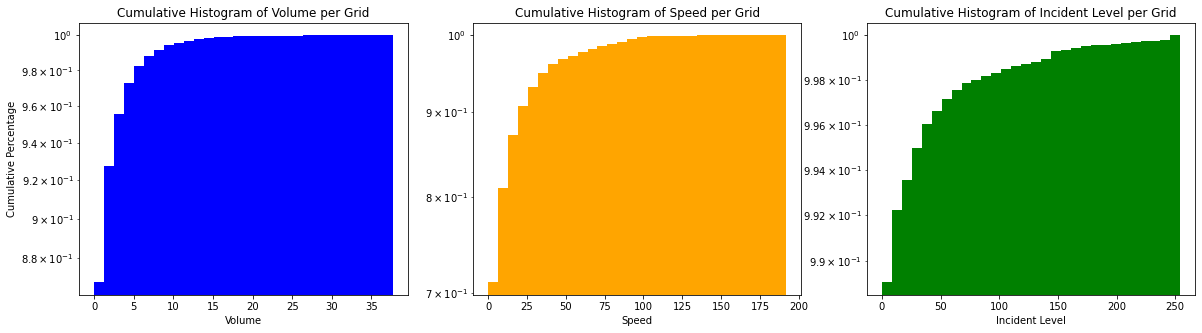

In [37]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
label = ["Volume","Speed","Incident Level"]
color = ["blue","orange","green"]
for i, data in enumerate([v_miu, s_miu, i_miu]):
    ax = axes[i]
    ax.hist(data, bins=30, color=color[i], weights=np.ones(len(data)) / len(data),cumulative=True,)
    ax.set_yscale("log")
    ax.set_title(f"Cumulative Histogram of {label[i]} per Grid")
    ax.set_xlabel(f"{label[i]}")
#     ax.set_ylim(0.7,1)
axes[0].set_ylabel("Cumulative Percentage")
plt.savefig(os.path.join(FIG_DIR,"features_hist.pdf"), bbox_inches="tight")
plt.show()

# Explore variation of speed/volume with time

In [5]:
# Flat days
incident_arr = incident_arr.reshape(-1, incident_arr.shape[-2], incident_arr.shape[-1])
volume_arr = volume_arr.reshape(-1, volume_arr.shape[-2], volume_arr.shape[-1])
speed_arr = speed_arr.reshape(-1, speed_arr.shape[-2], speed_arr.shape[-1])

In [17]:
def plot_timeseries(arr, title, pixel, fig_path, oneDay=False):
    pixel_ts = arr[:, pixel[0], pixel[1]]
    plt.figure(figsize=(15,4))
    plt.plot(pixel_ts)
    if not oneDay:
        plt.xticks(np.arange(0,5000,288), file_names, rotation=90)
    plt.grid("on")
    plt.xlabel("Timestamps")
    plt.ylabel(title)
    
    if title=="Volume":
        plt.ylim(-1,100)
    elif title=="Speed":
        plt.ylim(-1,150)
    else:
        plt.ylim(-1,256)
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

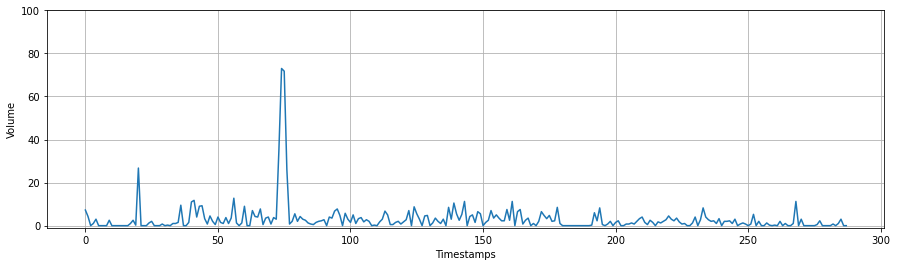

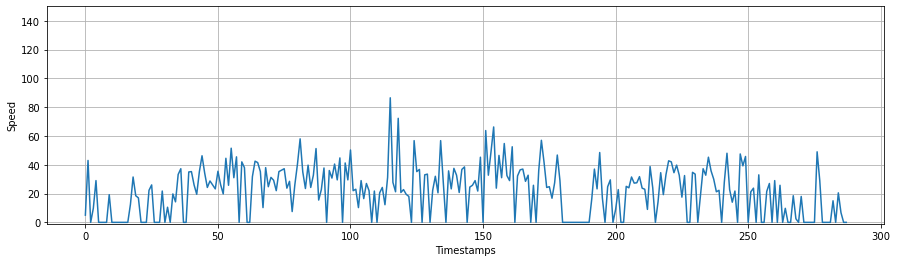

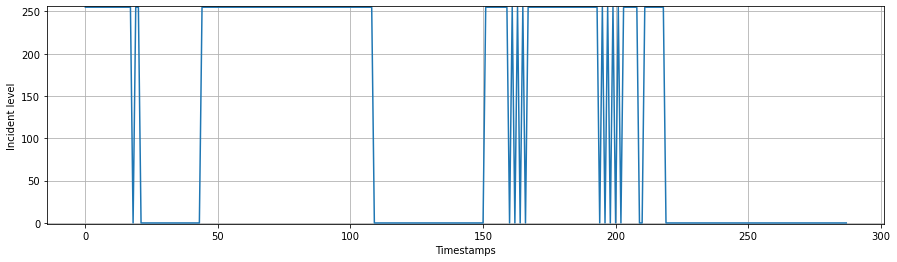

In [25]:
oneDay =True
day = 8
pixel = [286,121]
day_idx = day*288
if oneDay:
    fig_path = os.path.join(FIG_DIR, f"pixel_timeseries_p{pixel[0]}-{pixel[1]}_d{day}_")
    plot_timeseries(volume_arr[day_idx:day_idx+288], "Volume", pixel, fig_path+"v.png", oneDay=oneDay)
    plot_timeseries(speed_arr[day_idx:day_idx+288], "Speed", pixel, fig_path+"s.png", oneDay=oneDay)
    plot_timeseries(incident_arr[day_idx:day_idx+288], "Incident level", pixel, fig_path+"icd.png", oneDay=oneDay)
else:
    fig_path = os.path.join(FIG_DIR, f"pixel_timeseries_p{pixel[0]}-{pixel[1]}_all_")
    plot_timeseries(volume_arr, "Volume", pixel, fig_path+"v.png", oneDay=oneDay)
    plot_timeseries(speed_arr, "Speed", pixel, fig_path+"s.png", oneDay=oneDay)
    plot_timeseries(incident_arr, "Incident level", pixel, fig_path+"icd.png", oneDay=oneDay)

We can plot some pixels with high variations of incident levels.

[229,242] Icd = 255 from 0909 to 1029 -> less volume and slower speed during these days

[230,244] Icd = 255 from 0909 to 1019 -> less volume and slower speed from 0909 to 1029

[232,245] Icd >= 150 [0909, 1108] -> speed not impacted, 